Meteobike Linear Regression


In [6]:
import os
import sys
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

In [2]:
sys.path.append("../../src")
import main

<Axes: >

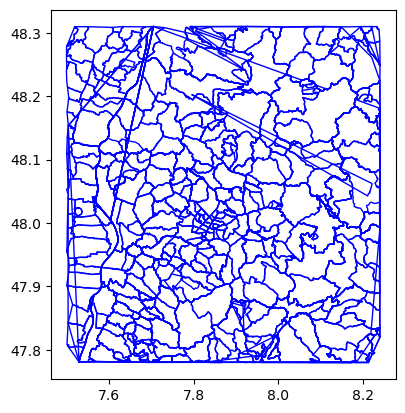

In [49]:
# for longitude and latitude, extract name of city district from OSM

# load OSM data
from pyrosm import OSM
from pyrosm import get_data
#fp = get_data("/Users/lisawink/Documents/paper1/data/raw_data/Geofabrik_Freiburg/freiburg-regbez-latest.osm.pbf")
fp = get_data("Freiburg")
osm = OSM(fp)

# Read all boundaries using the default settings
boundaries = osm.get_boundaries()
boundaries.plot(facecolor="none", edgecolor="blue")

In [8]:
# calculate distance from city centre
def city_centre_distance(stations, city_centre, input_crs='EPSG:4326', output_crs='EPSG:31468', lat_column = 'station_lat', lon_column = 'station_lon'):
    """city centre in input crs"""
    geometry = [Point(xy) for xy in zip(stations[lon_column], stations[lat_column])]
    stn_gdf = gpd.GeoDataFrame(stations, crs=input_crs, geometry=geometry)

    stn_gdf = stn_gdf.to_crs(output_crs)

    city_centre_gdf = gpd.GeoDataFrame({'geometry': [city_centre]}, crs=input_crs)
    city_centre = city_centre_gdf.to_crs(output_crs).geometry[0]
    stn_gdf['city_centre_distance'] = stn_gdf.distance(city_centre)
    return stn_gdf

Radius 50

In [143]:
radius = 50
stn_buffers = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_processed_station_params_' + str(radius) + '.parquet')
city_centre = Point(7.8439085,47.9976443)
stn_buffers = city_centre_distance(stn_buffers, city_centre, input_crs='EPSG:4326', output_crs='EPSG:31468', lat_column = 'Latitude', lon_column = 'Longitude')

In [144]:
boundaries.to_crs(stn_buffers.crs, inplace=True)

In [145]:
# spatial join with OSM data
stn_buffers = gpd.sjoin(stn_buffers, boundaries, how='left', predicate='within')

In [146]:
stn_buffers['name'].head(100)

0     Freiburg im Breisgau
0            Altstadt-Ring
0                 Altstadt
1     Freiburg im Breisgau
1            Altstadt-Ring
              ...         
31                  Wiehre
32    Freiburg im Breisgau
32        Unterwiehre-Nord
32                  Wiehre
33    Freiburg im Breisgau
Name: name, Length: 100, dtype: object

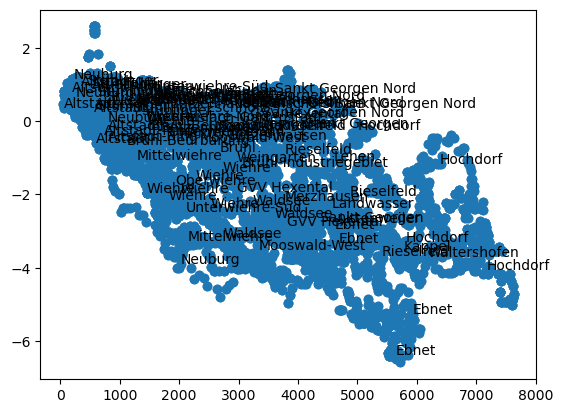

In [147]:
plt.scatter(stn_buffers['city_centre_distance'], stn_buffers['Temperature_diff_K'])
# for every 50 points, add name of city district
for i, txt in enumerate(stn_buffers['name']):
    if txt != 'Freiburg im Breisgau' and txt != 'Landkreis Breisgau-Hochschwarzwald':
        if i % 100 == 0:
            plt.annotate(txt, (stn_buffers['city_centre_distance'].iloc[i], stn_buffers['Temperature_diff_K'].iloc[i]))

In [148]:
X = sm.add_constant(stn_buffers['city_centre_distance'])  # Add constant for regression
model = sm.OLS(stn_buffers['Temperature_diff_K'], X).fit()

# Get the predicted values (fitted values)
y_pred = model.fittedvalues

# Calculate the residuals (errors)
residuals = stn_buffers['Temperature_diff_K'] - y_pred

In [149]:
stn_buffers['residuals'] = residuals


Text(0, 0.5, 'Temperature difference (K)')

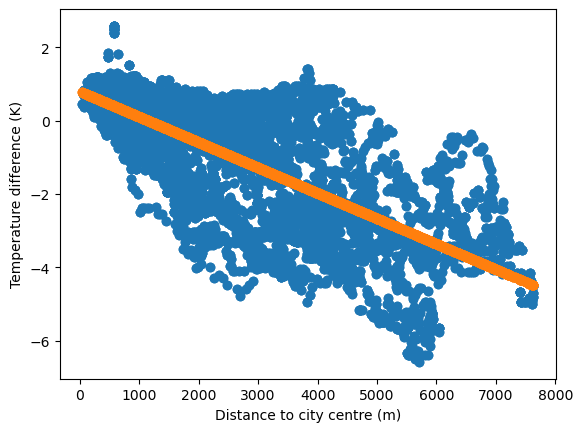

In [150]:
plt.scatter(stn_buffers['city_centre_distance'],stn_buffers['Temperature_diff_K'])
plt.scatter(stn_buffers['city_centre_distance'],y_pred)
plt.xlabel('Distance to city centre (m)')
plt.ylabel('Temperature difference (K)')

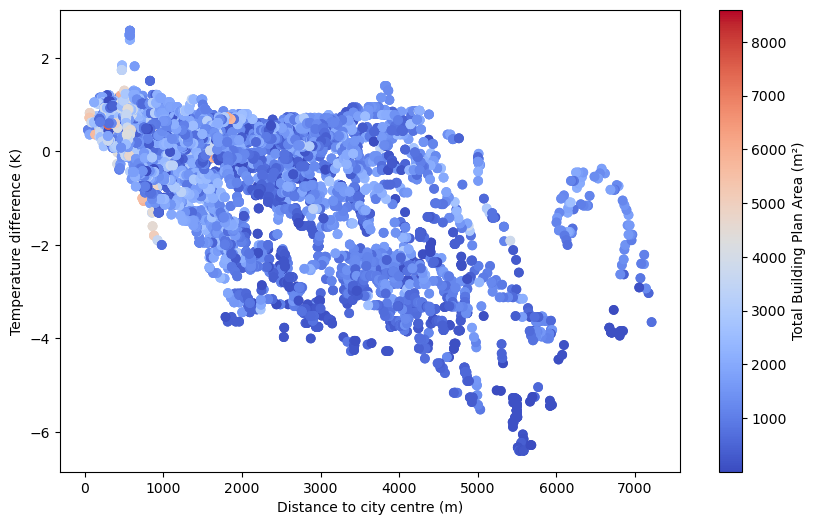

In [163]:
plt.figure(figsize=(10,6))
l = plt.scatter(stn_buffers['city_centre_distance'],stn_buffers['Temperature_diff_K'],c=stn_buffers['BuAre_sum'],cmap='coolwarm')
#plt.scatter(stn_buffers['city_centre_distance'],y_pred)
plt.xlabel('Distance to central station (m)')
plt.ylabel('Temperature difference (K)')
plt.colorbar(l,label='Total Building Plan Area (m²)')

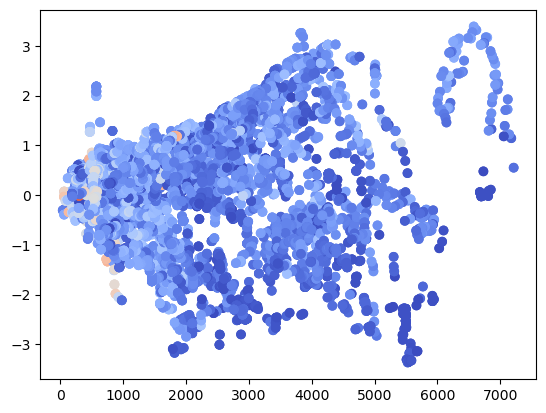

In [158]:
plt.scatter(stn_buffers['city_centre_distance'],residuals,c=stn_buffers['BuAre_sum'],cmap='coolwarm')
plt.xlabel('Distance to city centre (m)')

In [87]:
# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

for i in params:
    # perform linear regression
    X = sm.add_constant(stn_nona[i])  # Add constant for regression
    model = sm.OLS(stn_nona['residuals'], X).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.660
Date:                Wed, 19 Mar 2025   Prob (F-statistic):              0.198
Time:                        10:41:26   Log-Likelihood:                -2188.5
No. Observations:                1388   AIC:                             4381.
Df Residuals:                    1386   BIC:                             4392.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3541      0.066      5.394      0.0

In [154]:
# split into training and testing and try all parameters

from sklearn.model_selection import train_test_split

params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

X = stn_nona[params]
y = stn_nona['residuals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     16.06
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.55e-33
Time:                        11:38:51   Log-Likelihood:                -4537.3
No. Observations:                2987   AIC:                             9101.
Df Residuals:                    2974   BIC:                             9179.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.5835      0.878  

In [152]:
# try lasso regression

from sklearn.linear_model import Lasso

params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)


0.20165639368219523


In [ ]:
#print model summary of lasso
print(lasso.coef_)
print(lasso.intercept_)
print(lasso.sparse_coef_)
print(lasso.n_iter_)


In [153]:
# lasso features
pd.DataFrame(lasso.coef_, index=params)

,0
BuAre_sum,0.000748
BuVol_3D_sum,-0.000038
BuEWA_3D_sum,0.000006
BuIBD,-0.031530
BuAdj,-0.000000
BuSWR_3D_median,0.000000
BuHt_wmean,0.140579
StrHW_median,0.000000
SVF_3D_mean,-0.000000
BuSqC_wmean,-0.000000


radius 500

In [89]:
radius = 500
stn_buffers = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_processed_station_params_' + str(radius) + '.parquet')
city_centre = Point(7.8439085,47.9976443)
stn_buffers = city_centre_distance(stn_buffers, city_centre, input_crs='EPSG:4326', output_crs='EPSG:31468', lat_column = 'Latitude', lon_column = 'Longitude')

In [90]:
# spatial join with OSM data
stn_buffers = gpd.sjoin(stn_buffers, boundaries, how='left', predicate='within')

In [91]:
X = sm.add_constant(stn_buffers['city_centre_distance'])  # Add constant for regression
model = sm.OLS(stn_buffers['Temperature_diff_K'], X).fit()

# Get the predicted values (fitted values)
y_pred = model.fittedvalues

# Calculate the residuals (errors)
residuals = stn_buffers['Temperature_diff_K'] - y_pred

In [92]:
stn_buffers['y_pred'] = y_pred
stn_buffers['residuals'] = residuals

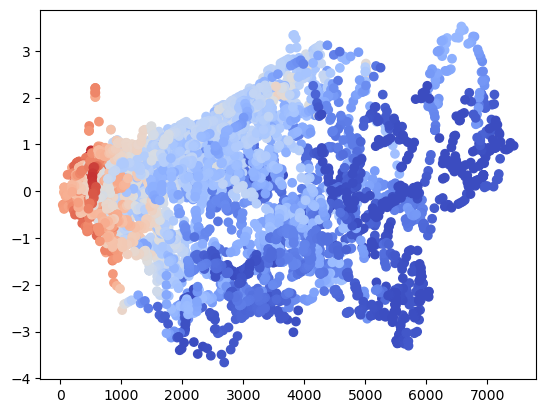

In [93]:
plt.scatter(stn_buffers['city_centre_distance'],residuals,c=stn_buffers['BuAre_sum'],cmap='coolwarm')

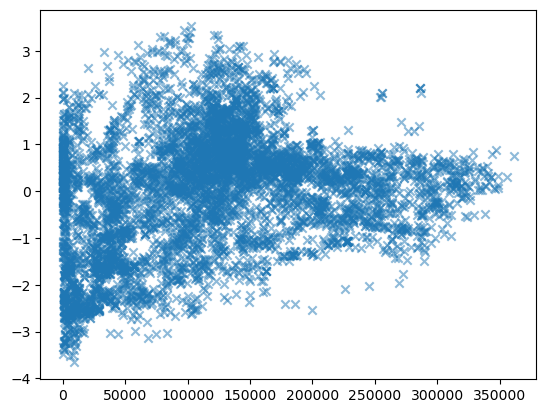

In [94]:
plt.scatter(stn_buffers['BuAre_sum'],stn_buffers['residuals'],marker='x',alpha=0.5)

In [95]:
# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

for i in params:
    # perform linear regression
    X = sm.add_constant(stn_nona[i])  # Add constant for regression
    model = sm.OLS(stn_nona['residuals'], X).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     458.8
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.02e-97
Time:                        10:42:27   Log-Likelihood:                -8614.2
No. Observations:                5346   AIC:                         1.723e+04
Df Residuals:                    5344   BIC:                         1.725e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5467      0.031    -17.439      0.0

In [96]:
# split into training and testing and try all parameters

from sklearn.model_selection import train_test_split

X = stn_nona[params]
y = stn_nona['residuals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     229.5
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:42:28   Log-Likelihood:                -6001.9
No. Observations:                4276   AIC:                         1.203e+04
Df Residuals:                    4263   BIC:                         1.211e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.4050      1.250  

In [61]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

In [110]:
# just city centre

params = ['city_centre_distance']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     4601.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:46:40   Log-Likelihood:                -7840.7
No. Observations:                4752   AIC:                         1.569e+04
Df Residuals:                    4750   BIC:                         1.570e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7915 

In [112]:
# model city centre

# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['city_centre_distance','BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     711.6
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:49:25   Log-Likelihood:                -5868.4
No. Observations:                4276   AIC:                         1.176e+04
Df Residuals:                    4262   BIC:                         1.185e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.5548 

In [114]:
# without city centre

# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())
model.

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     663.9
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:49:36   Log-Likelihood:                -6052.5
No. Observations:                4276   AIC:                         1.213e+04
Df Residuals:                    4263   BIC:                         1.221e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.5136      1.280  

In [164]:
model.f_pvalue

1.5497238719779623e-33

In [166]:
model.fvalue

16.056723249904984

In [115]:
# just buare_sum

# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['BuAre_sum']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     5051.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:11:36   Log-Likelihood:                -7407.2
No. Observations:                4624   AIC:                         1.482e+04
Df Residuals:                    4622   BIC:                         1.483e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9484      0.031    -94.637      0.0

In [116]:

# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['BuAre_sum','StrHW_median']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     2349.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:12:08   Log-Likelihood:                -6814.1
No. Observations:                4314   AIC:                         1.363e+04
Df Residuals:                    4311   BIC:                         1.365e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.2246      0.056    -39.846   

In [117]:

# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['BuAre_sum','StrHW_median','BuFra_3D_wmean']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     1588.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:12:24   Log-Likelihood:                -6810.2
No. Observations:                4314   AIC:                         1.363e+04
Df Residuals:                    4310   BIC:                         1.365e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.3410      0.136    -24.

In [122]:

# regress residuals on parameters in stn_buffers and find out which parameters are most important

# drop columns that are not needed

params = ['BuAre_sum','BuIBD','BuHt_wmean']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# perform linear regression
X_train = sm.add_constant(X_train)  # Add constant for regression
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

# print r squared for test set
X_test = sm.add_constant(X_test)  # Add constant for regression
y_pred = model.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)

                            OLS Regression Results                            
Dep. Variable:     Temperature_diff_K   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     1694.
Date:                Wed, 19 Mar 2025   Prob (F-statistic):               0.00
Time:                        11:16:48   Log-Likelihood:                -7280.6
No. Observations:                4540   AIC:                         1.457e+04
Df Residuals:                    4536   BIC:                         1.459e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9756      0.075    -39.776      0.0

In [118]:
# try lasso regression

from sklearn.linear_model import Lasso

params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

stn_nona = stn_buffers.dropna(subset=params +['Temperature_diff_K'])

X = stn_nona[params]
y = stn_nona['Temperature_diff_K']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
r2 = 1 - sum((y_test - y_pred)**2) / sum((y_test - np.mean(y_test))**2)
print(r2)


0.6353591014813551


In [120]:
# lasso features
pd.DataFrame(lasso.coef_, index=params)

,0
BuAre_sum,0.000046
BuVol_3D_sum,-0.000002
BuEWA_3D_sum,-0.000002
BuIBD,-0.007387
BuAdj,-0.000000
BuSWR_3D_median,0.000000
BuHt_wmean,0.234924
StrHW_median,-0.000000
SVF_3D_mean,-0.000000
BuSqC_wmean,-0.000000


Text(0.5, 1.0, 'Explained variance by PCA components')

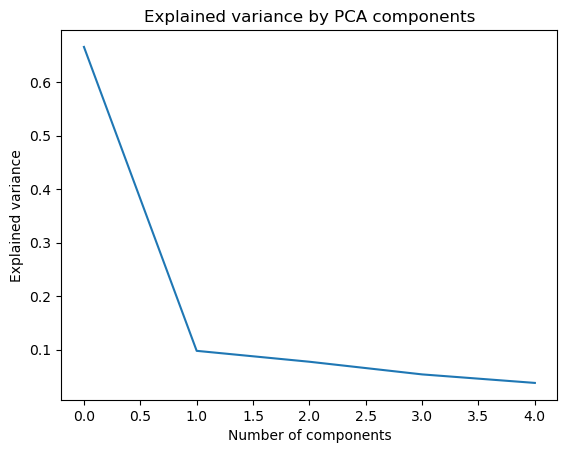

In [127]:
# PCA of params

from sklearn.decomposition import PCA

params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

stn_nona = stn_buffers.dropna(subset=params)

#PCA
scaler = StandardScaler()
scaler.fit(stn_nona[params])
X_scaled = scaler.transform(stn_nona[params])

pca = PCA(n_components=5)
pca.fit(X_scaled)

# plot explained variance
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance by PCA components')


Text(0, 0.5, 'cumulative explained variance')

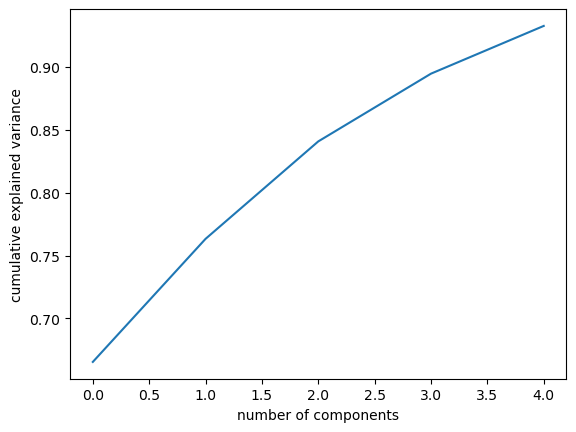

In [128]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [129]:
df = pd.DataFrame(pca.components_, columns=params)

In [130]:
df

,BuAre_sum,BuVol_3D_sum,BuEWA_3D_sum,BuIBD,BuAdj,BuSWR_3D_median,BuHt_wmean,StrHW_median,SVF_3D_mean,BuSqC_wmean,BuFra_3D_wmean,StrClo400_median
0,0.337643,0.343011,0.343909,-0.220629,-0.314998,0.294939,0.288092,0.324336,-0.331821,-0.179162,0.022682,0.290290
1,0.073157,0.001823,-0.010644,-0.245528,-0.065561,0.153463,-0.397418,0.045087,0.003917,0.342333,-0.782071,0.132595
2,0.106645,0.144254,0.070045,0.398030,0.184701,-0.244266,0.092371,0.066574,0.021038,-0.639613,-0.522721,-0.122285
3,0.032367,0.126650,0.054596,0.722450,0.170969,0.046395,0.081013,0.297619,-0.035525,0.497201,0.012789,0.287821
4,-0.261828,-0.187073,-0.292661,0.190638,-0.351935,0.514239,-0.017773,0.114478,0.428383,-0.314962,-0.019717,0.299388


In [131]:
pc = pca.transform(X_scaled)

df1 = pd.DataFrame(pc, columns=['PC1','PC2','PC3','PC4','PC5'])

In [135]:
df1['Temperature_diff_K'] = stn_buffers.dropna(subset=params)['Temperature_diff_K']

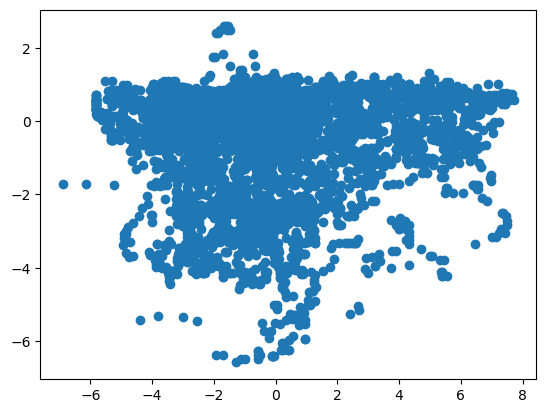

In [136]:
# plot PC1 vs Temperature_diff_K
plt.scatter(df1['PC1'],df1['Temperature_diff_K'])

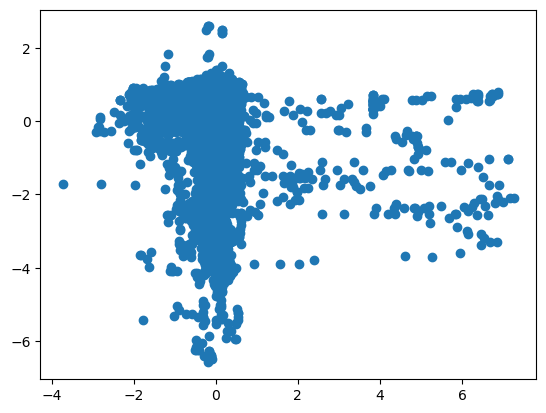

In [138]:
plt.scatter(df1['PC2'],df1['Temperature_diff_K'])

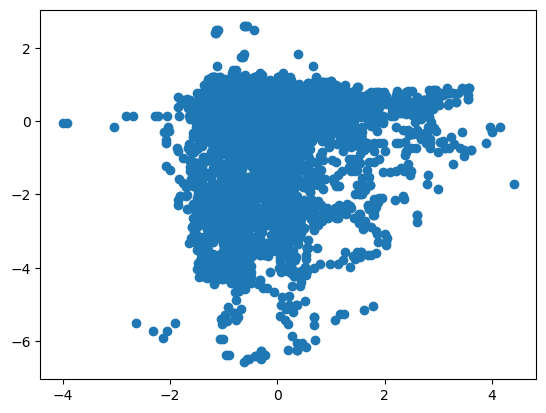

In [139]:
plt.scatter(df1['PC3'],df1['Temperature_diff_K'])

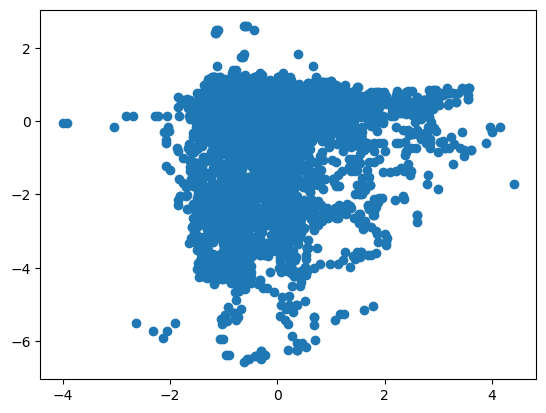

In [140]:
plt.scatter(df1['PC3'],df1['Temperature_diff_K'])

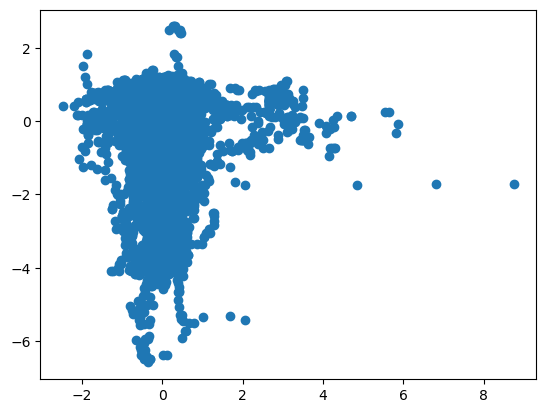

In [141]:
plt.scatter(df1['PC4'],df1['Temperature_diff_K'])

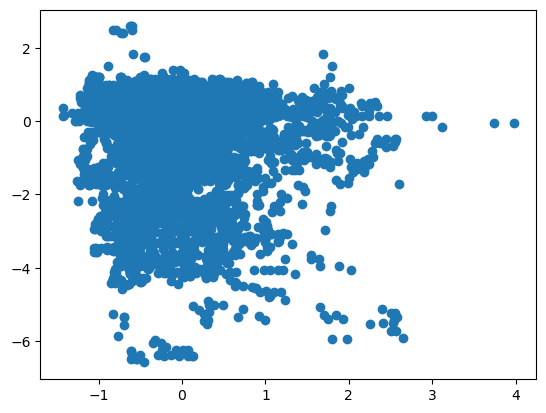

In [142]:
plt.scatter(df1['PC5'],df1['Temperature_diff_K'])